In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

23701
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
path_qucf_ = "../QuCF/simulations/LCHS/KvN/BE-2/"
for _ in range(100):
    plt.close()

In [4]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)
# ----------------------------------------

nx_ = 7 
nk_    = 7
k_max_ = 10
flag_asin, flag_Cheb = True, True

# --- Linear x-grid ---
Nx_ = 1 << nx_
x_lin_ = np.linspace(-1.0, 1.0, Nx_)  
dx_    = np.diff(x_lin_)[0]
print("nx: {:d}".format(nx_))

# --- k-grid ---
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

_, Aa_, Ah_, Aa_asin_, Ah_asin_ = kvn.construct_UW_matrix_1D(
    x_lin_, F_, 
    flag_asin = True, flag_Cheb = flag_Cheb
)

# --- LCHS matrices ---
# REMARK: the normalized matrices Bm_asin_ and Bk_asin_ are the same up to a sign.
Ba_, Bm_, Bk_, norm_a_x, norm_m_x, norm_k_x = \
    kvn.compute_norm_matrices_LCHS_with_output_norm(Aa_, Ah_, k_max_, dk_)
print("\n---")
Ba_asin_, Bm_asin_, Bk_asin_, norm_a_asin, norm_m_asin, norm_k_asin = \
    kvn.compute_norm_matrices_LCHS_with_output_norm(Aa_asin_, Ah_asin_, k_max_, dk_)

# --- Rescale matrices to the BULK elements of the D-matrices ---
# rescaling at the edge should be corrected afterwards
dd_diags_ref_  = kvn.get_rescaled_diags_BE(Ba_, Bm_, Bk_)
dd_diags_asin_ = kvn.get_rescaled_diags_BE(Ba_asin_, Bm_asin_, Bk_asin_)

nx: 7
Matrix Ba:	 nonsparsity, coefnorm: 2, 6.359e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 1.651e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 2.600e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

---
Matrix Ba:	 nonsparsity, coefnorm: 2, 2.899e+02
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 7.529e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 1.186e+02

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333



-------------------------------------------------------------------------
--- Ba-norm ---


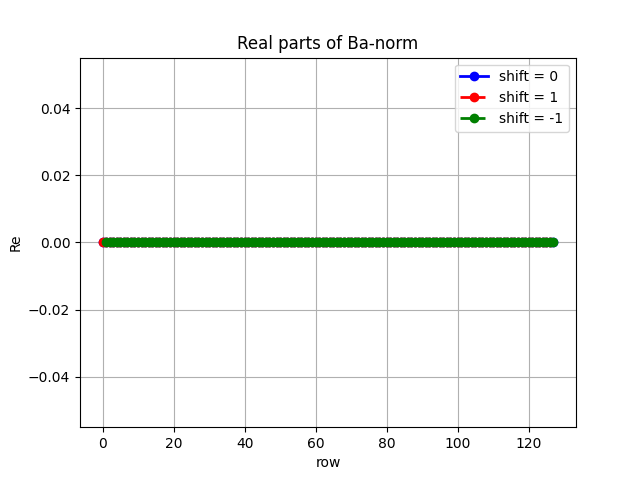

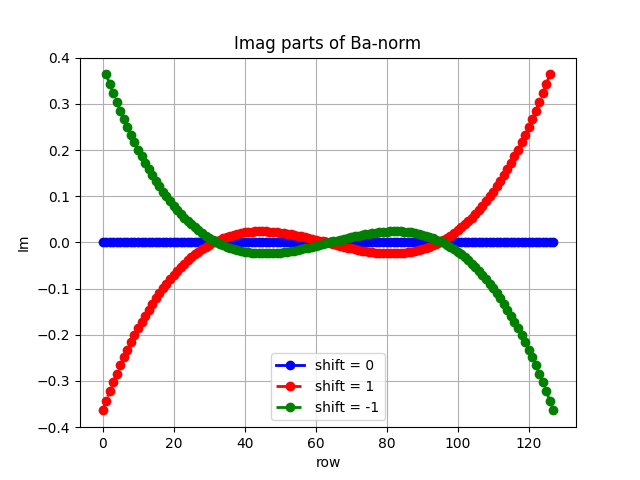


-------------------------------------------------------------------------
--- B-kmax-norm ---


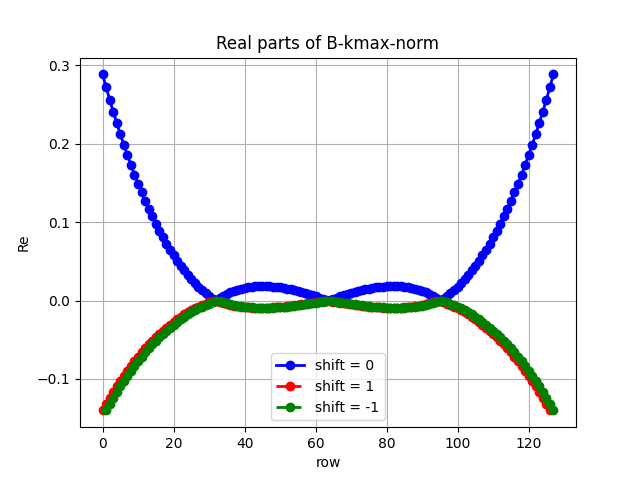

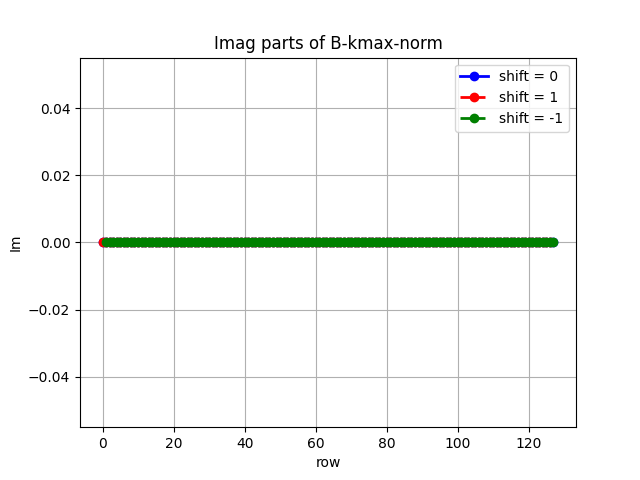

In [4]:
# ---------------------------------------------------------------
# --- Print diagonals of normalized (non-rescaled) matrices ---
# ---------------------------------------------------------------
mix.reload_module(kvn)
def get_plot_diags(flag_save):
    print()
    print("-------------------------------------------------------------------------")
    print("--- Ba-norm ---")
    A_plot, A_name, flag_save_real = Ba_,     "Ba-norm",     False
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)

    print()
    print("-------------------------------------------------------------------------")
    print("--- B-kmax-norm ---")
    A_plot, A_name, flag_save_real = Bk_, "B-kmax-norm", True
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)
    del flag_save, A_plot, A_name, flag_save_real
    return
# ------------------------------------------------------------------
get_plot_diags(flag_save = False)

In [5]:
# -----------------------------------------------------------
# --- Choose the MATRIX and Compute normalized SUMS ---
# -----------------------------------------------------------
mix.reload_module(kvn)

sel_matrix = "Bk"  # or "Ba" or "Bk"

# --- Choose the reference matrix ---
if flag_asin:
    norm_a_ = norm_a_asin
    norm_k_ = norm_k_asin
    if sel_matrix == "Ba":
        print("take Ba_asin.imag")
        A_ref = np.array(Ba_asin_.imag)
    else:
        print("take Bk_asin.real")
        A_ref = np.array(Bk_asin_.real)
else:
    norm_a_ = norm_a_x
    norm_k_ = norm_k_x
    if sel_matrix == "Ba":
        print("take Ba.imag")
        A_ref = np.array(Ba_.imag)
    else:
        print("take Bk.real")
        A_ref = np.array(Bk_.real)

# --- Compute normalized (non-scaled) diagonals of the reference matrix ---
diag_D_, _ = mix.get_diag(A_ref, i_shift = 0)
diag_R_, _ = mix.get_diag(A_ref, i_shift = 1)
diag_L_, _ = mix.get_diag(A_ref, i_shift = -1)

# --- Compute the sums ---
ar_sD, ar_RR, ar_CR, ar_RL, ar_CL, sum_D, sum_R_k, sum_L_k, sum_R_a, sum_L_a \
   = kvn.get_sums_UW_KvN_LCHS_matrices_norm(
      x_lin_, F_, norm_a_, norm_k_, dk_,
      flag_asin = flag_asin, flag_Cheb = flag_Cheb
   )

ar_sD_x, ar_RR_x, ar_CR_x, ar_RL_x, ar_CL_x, sum_D_x, sum_R_k_x, sum_L_k_x, sum_R_a_x, sum_L_a_x \
   = kvn.get_sums_UW_KvN_LCHS_matrices_norm(
      x_lin_, F_, norm_a_, norm_k_, dk_,
      flag_asin = False, flag_Cheb = False
   )

# --- Row indices ---
row_D = range(Nx_)
row_R = range(Nx_-1)
row_L = range(1,Nx_)

take Bk_asin.real


sign-D:   eb, ids: 1,  [43, 63, 83]
delta-RR: eb, ids: 0,  [43, 63, 83]
delta-CR: eb, ids: 1,  [42, 62, 82]
delta-RL: eb, ids: 1,  [43, 63, 83]
delta-CL: eb, ids: 0,  [44, 64, 84]


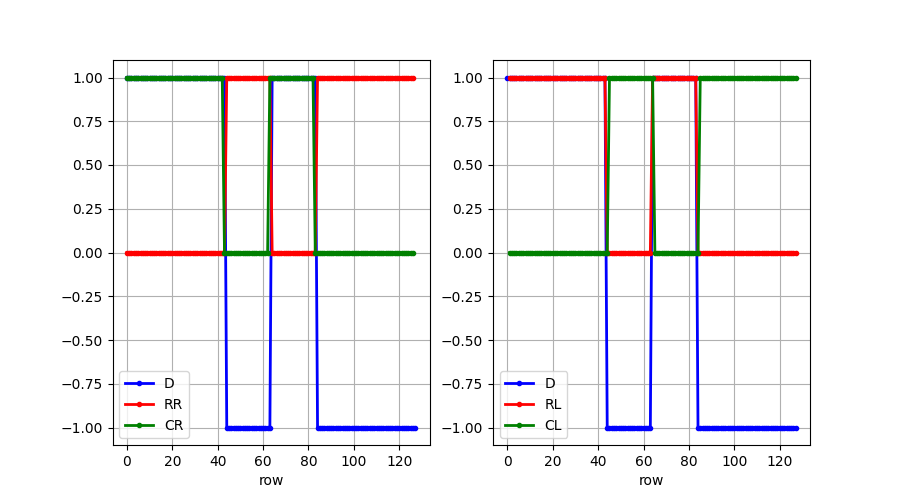

In [6]:
# -------------------------------------------------------------
# --- Plot signs and delta-functions ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_signs_delta(flag_x = False):
    def comp_ids(arr, id_sh = 0):
        temp = arr[0]
        ids_res = []  # indices AFTER each the considered array changes value
        for ix in range(len(arr)):
            if arr[ix] != temp:
                temp = arr[ix]
                ids_res.append(ix - 1 + id_sh)
        return ids_res
    # ---------------------------------------------

    if flag_x:
        ar_sD_curr = np.array(ar_sD_x)
        ar_RR_curr = np.array(ar_RR_x)
        ar_CR_curr = np.array(ar_CR_x)
        ar_RL_curr = np.array(ar_RL_x)
        ar_CL_curr = np.array(ar_CL_x)
    else:
        ar_sD_curr = np.array(ar_sD)
        ar_RR_curr = np.array(ar_RR)
        ar_CR_curr = np.array(ar_CR)
        ar_RL_curr = np.array(ar_RL)
        ar_CL_curr = np.array(ar_CL)


    # --- Find indices ---
    ids_D  = comp_ids(ar_sD_curr)
    ids_RR = comp_ids(ar_RR_curr)
    ids_CR = comp_ids(ar_CR_curr)
    ids_RL = comp_ids(ar_RL_curr, 1)
    ids_CL = comp_ids(ar_CL_curr, 1)
    print("sign-D:   eb, ids: {:d}, ".format(int(ar_sD_curr[0])), ids_D)
    print("delta-RR: eb, ids: {:d}, ".format(int(ar_RR_curr[0])), ids_RR) # = ids_D
    print("delta-CR: eb, ids: {:d}, ".format(int(ar_CR_curr[0])), ids_CR) # = ids_D - 1
    print("delta-RL: eb, ids: {:d}, ".format(int(ar_RL_curr[0])), ids_RL) # = ids_D
    print("delta-CL: eb, ids: {:d}, ".format(int(ar_CL_curr[0])), ids_CL) # = ids_D + 1


    # --- Plotting ---
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(121)
    ax.plot(row_D,  ar_sD_curr, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_R,  ar_RR_curr, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RR")
    ax.plot(row_R,  ar_CR_curr, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CR")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)

    ax = fig.add_subplot(122)
    ax.plot(row_D,  ar_sD_curr, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_L,  ar_RL_curr, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RL")
    ax.plot(row_L,  ar_CL_curr, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CL")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)
    plt.show()
    return ids_D
# --------------------------------------------------------------------------------------------
ids_D_signs_ = plot_signs_delta(flag_x = False)

sum: sum_D: 1.110e-16


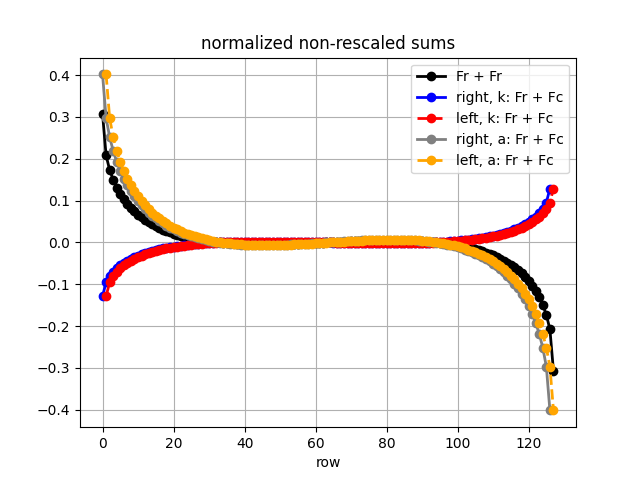

In [7]:
# -------------------------------------------------------------
# --- Plot various sums ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_norm_sums():
    print("sum: sum_D: {:0.3e}".format(np.sum(sum_D)))

    # --- Compara
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_D,  sum_D, 
        color='black', linewidth = 2, linestyle='-', marker = "o",
        label = "Fr + Fr"
    )

    ax.plot(
        row_R, sum_R_k, 
        color='b', linewidth = 2, linestyle='-', marker = "o",
        label = "right, k: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_k, 
        color='r', linewidth = 2, linestyle='--', marker = "o",
        label = "left, k: Fr + Fc"
    )  # the same as sum_RR for real F

    ax.plot(
        row_R, sum_R_a, 
        color='gray', linewidth = 2, linestyle='-', marker = "o",
        label = "right, a: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_a, 
        color='orange', linewidth = 2, linestyle='--', marker = "o",
        label = "left, a: Fr + Fc"
    )  # the same as sum_RL for real F

    plt.xlabel('row')
    plt.legend()
    plt.title("normalized non-rescaled sums")
    plt.grid(True)
    plt.show()
    return
# -------------------------------------------------------------------------
plot_norm_sums()

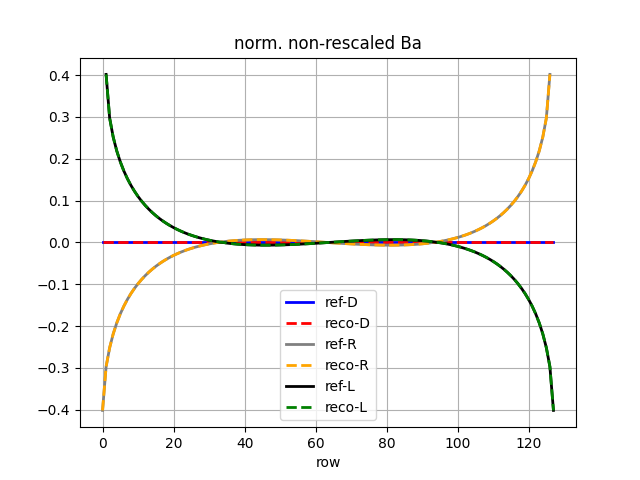

D: ref - reco: 0.000e+00
R: ref - reco: 5.551e-17
L: ref - reco: 5.551e-17


In [8]:
# -----------------------------------------------------------------------
# --- Reconstruct normalized non-rescaled diagonals from the sums ---
# -----------------------------------------------------------------------
mix.reload_module(kvn)
def reconstruct_norm_diags():
    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a + ar_CR * sum_R_a)
        diag_L_reco =   (ar_RL * sum_L_a + ar_CL * sum_L_a)

        # diag_R_reco = -np.array(sum_R_a)
        # diag_L_reco = np.array(sum_L_a)

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D * ar_sD
        diag_R_reco = - ar_RR * sum_R_k + ar_CR * sum_R_k
        diag_L_reco =   ar_RL * sum_L_k - ar_CL * sum_L_k

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_,     color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. non-rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_diags()

In [7]:
# ---------------------------------------------------------------------
# --- GET rescaled sums (because of the influence of the OF oracle) ---
# --- Here, the rescaling is performed only to bulk points          ---
# ---------------------------------------------------------------------
def get_rescaled_sums():
    # rescaled sums for Bk:
    coef_R_k, coef_D = 0.250, 0.500
    sum_D_rs   = sum_D   / coef_D
    sum_R_k_rs = sum_R_k / coef_R_k

    # rescaled sum for Ba:
    coef_R_a = 0.500
    sum_R_a_rs   = sum_R_a / coef_R_a

    # ---
    sum_D_x_rs   = sum_D_x   / coef_D
    sum_R_k_x_rs = sum_R_k_x / coef_R_k
    sum_R_a_x_rs = sum_R_a_x / coef_R_a
    return sum_D_rs, sum_R_k_rs, sum_R_a_rs, sum_D_x_rs, sum_R_k_x_rs, sum_R_a_x_rs
# ----------------------------------------------------------------------------
sum_D_rs, sum_R_k_rs, sum_R_a_rs, sum_D_x_rs, sum_R_k_x_rs, sum_R_a_x_rs = get_rescaled_sums()

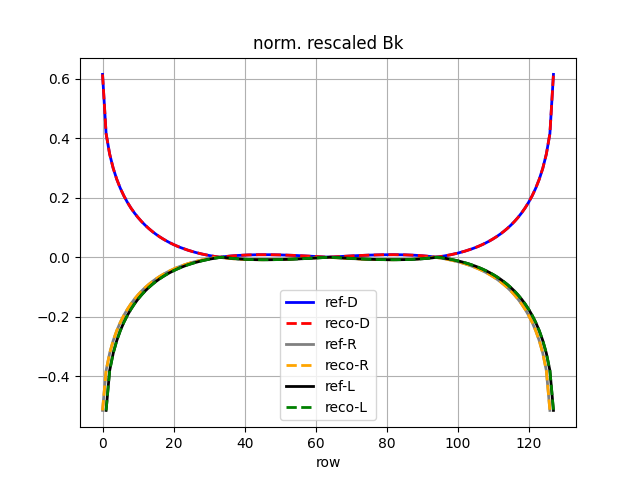

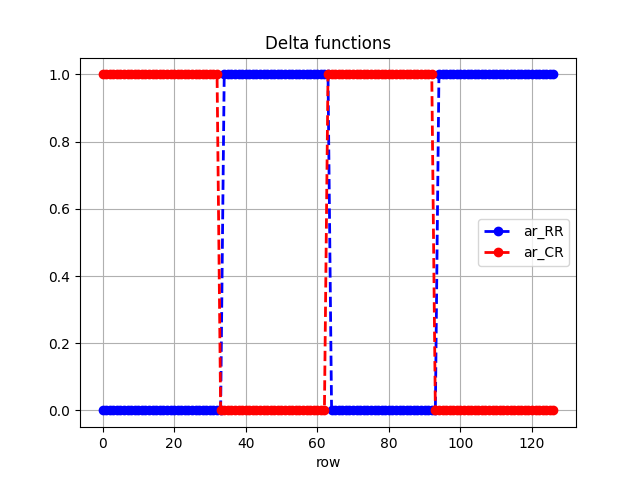

D: ref - reco: 1.110e-16
R: ref - reco: 1.110e-16
L: ref - reco: 1.110e-16


In [22]:
# -----------------------------------------------------------------------
# --- Reconstruct normalized rescaled diagonals from the sums ---
# -----------------------------------------------------------------------
def reconstruct_norm_rescaled_diags():
    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a_rs + ar_CR * sum_R_a_rs)
        diag_L_reco =   (ar_RL * sum_R_a_rs + ar_CL * sum_R_a_rs)

        diag_D_ref = np.zeros(Nx_)
        
        if flag_asin:
            diag_R_ref = dd_diags_asin_["diag_A_p1"]
            diag_L_ref = dd_diags_asin_["diag_A_m1"]
        else:
            diag_R_ref = dd_diags_ref_["diag_A_p1"]
            diag_L_ref = dd_diags_ref_["diag_A_m1"]

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D_rs * ar_sD
        diag_R_reco = - ar_RR * sum_R_k_rs + ar_CR * sum_R_k_rs
        diag_L_reco =   ar_RL * sum_R_k_rs - ar_CL * sum_R_k_rs

        if flag_asin:
            diag_D_ref = dd_diags_asin_["diag_k_00"]
            diag_R_ref = dd_diags_asin_["diag_k_p1"]
            diag_L_ref = dd_diags_asin_["diag_k_m1"]
        else:
            diag_D_ref = dd_diags_ref_["diag_k_00"]
            diag_R_ref = dd_diags_ref_["diag_k_p1"]
            diag_L_ref = dd_diags_ref_["diag_k_m1"]
            

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_ref,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_ref,  color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_ref,  color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- Plotting the delta ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_R, ar_RR, '--b', marker = "o", linewidth = 2, label = "ar_RR")
    ax.plot(row_R, ar_CR, '--r', marker = "o", linewidth = 2, label = "ar_CR")

    plt.xlabel('row')
    plt.title("Delta functions")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- errors ---
    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ref - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ref - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ref - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_rescaled_diags()

In [8]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_extr_odd_even_sum(flag_interp, nx_fine):
    print("Taking {:s} sum".format(sel_sum_))
    
    sum_work_odd, sum_work_even = None, None

    # --- Fine grid ---
    x_fine = None
    if flag_interp:
        # Nx_fine = 2**nx_fine
        # dx_fine = 2. / Nx_fine
        # x_fine = np.zeros(Nx_fine)
        # for i in range(Nx_fine):
        #     x_fine[i] = -1.0 + dx_fine * i

        x_fine = np.linspace(-1.0, 1.0, 2**nx_fine)
        # x_fine = ch.get_Cheb_roots(2**nx_fine)
    
    # --- Choose the halfs ---
    if sel_sum_ == "D":
        sum_work = np.array(sum_D_rs)
        diag_ref = np.array(dd_diags_ref_["diag_k_00"])
        sum_x    = np.array(sum_D_x_rs)
    if sel_sum_ == "Rk":
        sum_work = np.array(sum_R_k_rs) 
        diag_ref = dd_diags_ref_["diag_k_p1"]
        sum_x    = np.array(sum_R_k_x_rs)
    if sel_sum_ == "Ra":
        sum_work = np.array(sum_R_a_rs)
        diag_ref = dd_diags_ref_["diag_A_p1"]
        sum_x    = np.array(sum_R_a_x_rs)

    # --- Interpolate onto a finer grid ---
    if sel_sum_ == "D": 
        if flag_interp:
            # --- Interpolating onto a fine grid ---
            # x_coarse = ch.get_Cheb_roots(len(sum_work))
            x_coarse = np.linspace(-1.0, 1.0, len(sum_work))

            f_interp = interpolate.CubicSpline(x_coarse, sum_work)
            sum_work = f_interp(x_fine)
            
            f_interp = interpolate.CubicSpline(x_coarse, diag_ref)
            diag_ref = f_interp(x_fine)
    else:
        if flag_interp:
            # --- Interpolating onto a fine grid ---
            x_coarse = np.linspace(-1.0, 1.0, len(sum_work))
            f_interp = interpolate.CubicSpline(x_coarse, sum_work)
            sum_work = f_interp(x_fine)
            
            x_coarse_diag = np.linspace(-1.0, 1.0, len(diag_ref))
            f_interp = interpolate.CubicSpline(x_coarse_diag, diag_ref)
            diag_ref = f_interp(x_fine)
        
        # --- Find the even and odd parts ---
        sum_work_even = 0.5 * (sum_work + sum_work[::-1])
        sum_work_odd  = 0.5 * (sum_work - sum_work[::-1])
        sum_work_ch = sum_work_even + sum_work_odd

        print("ref - check: {:0.3e}".format(
            np.max(np.abs(sum_work - sum_work_ch))
        ))

        # --- Plot the extrapolated sum ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            x_fine, sum_work, 
            color='red', linewidth = 2, linestyle='-',  
            label = "sum-work"
        )
        ax.plot(
            x_fine, sum_work_ch,  
            color='blue', linewidth = 2, linestyle='--',  
            label = "sum-work-ch"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Plot the even and odd parts ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            range(len(sum_work_even)), sum_work_even, 
            color='b', linewidth = 2, linestyle='--',  
            label = "sum-even"
        )
        ax.plot(
            range(len(sum_work_odd)), sum_work_odd, 
            color='r', linewidth = 2, linestyle='--',  
            label = "sum-odd"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()

    if flag_interp:
        x_coarse = np.linspace(-1.0, 1.0, len(sum_x))
        f_interp = interpolate.CubicSpline(x_coarse, sum_x)
        sum_x = f_interp(x_fine)

    print("sum of f_goal: {:0.3e}".format(
        np.sum(sum_work)
    ))
    
    # --- Return ---
    return sum_work, sum_x, sum_work_odd, sum_work_even, x_fine, diag_ref
# ----------------------------------------------------------------------
sel_sum_ = "D"  # "D", "Rk", "Ra" (independent of the chosen matrix)
flag_interp_ = False
nx_fine_ = 11

f_goal_, f_goal_x_, f_goal_odd_, f_goal_even_, x_fine_, diag_ref_ = get_extr_odd_even_sum(
    flag_interp = flag_interp_,
    nx_fine = nx_fine_
)

# REMARK: global_factor appears due to the transition from asin(y) back to x during the reconstruction
factor_global_Bk_ = 4.359e+00

Taking D sum
sum of f_goal: -2.220e-16


In [9]:
for _ in range(100):
    plt.close()


--------------------------------------------------------------------
--- Computing Chebyschev coefficients ---
--------------------------------------------------------------------

--- Main diagonal -----------------------------
Chosen profile: D
Chosen parity: 1

Minimization method is used.
Computation status:  1.4115070884986407e-30

Chosen polynomial's degree:	 128
Number of coefficients:		 64
max. abs. error: 5.551e-16


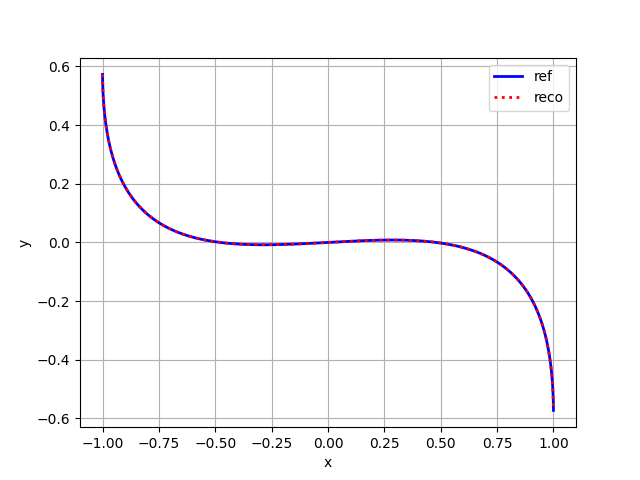

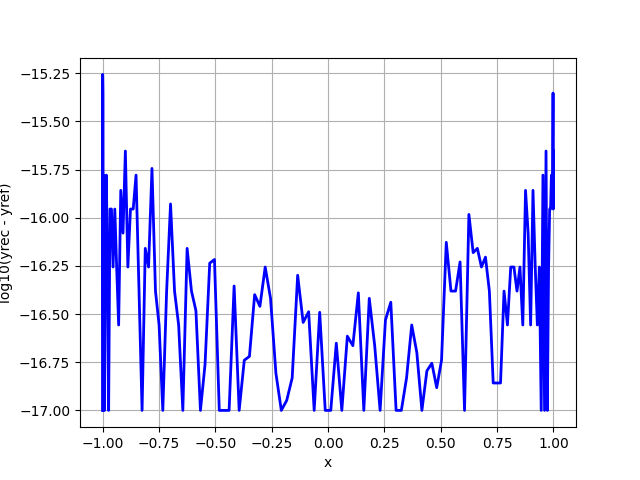

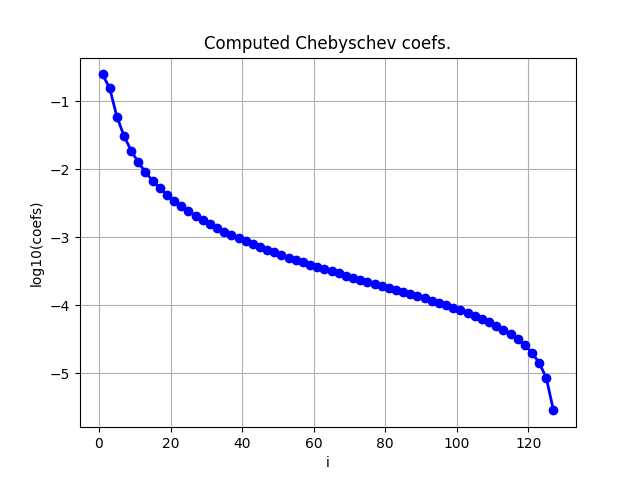


--------------------------------------------------------------------
--- Reconstructed profile ---
--------------------------------------------------------------------


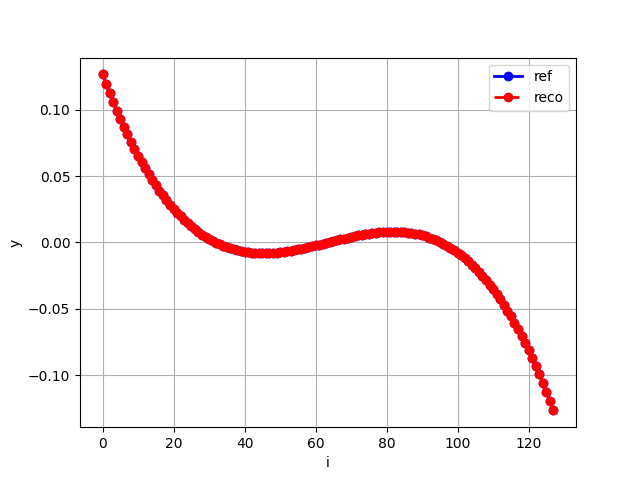

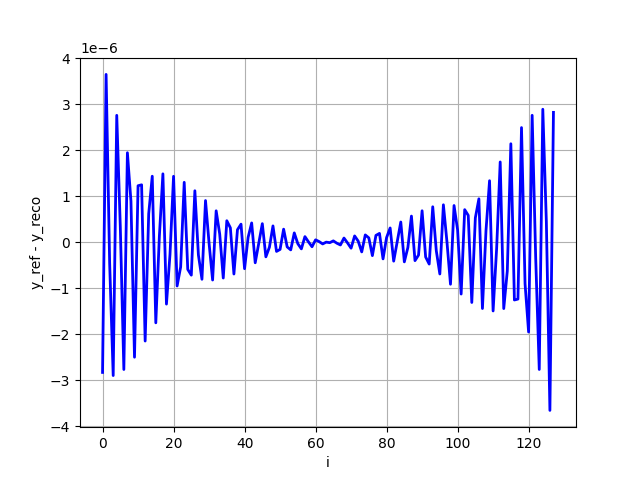

In [18]:
# ---------------------------------------------------------------
# --- Compute QSVT angles for the chosen sum ---
# ---------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(ch)
mix.reload_module(kvn)
def get_Cheb():
    # -----------------------------------------------------------------------------------
    def compute_Cheb_coefs(diag_ch, parity_1, Nd, flag_save_hdf5, flag_save_dat):
        sel_method = 0

        if flag_interp_:
            x_loc = x_fine_
        else:
            x_loc = x_lin_

        oo_ch_ = ch.Ch_()
        oo_ch_.choose_method(sel_method)
        oo_ch_.choose_func(
            -1, 0.0, 
            profile_in = diag_ch,
            name_prof  = sel_sum_,
            parity_in  = parity_1,
            path_root_in = "./jupyter-notebooks/NL/BE/coefs/",
            # x_grid = x_loc # !!!
        )
        oo_ch_.compute_Ch(Nd)
        oo_ch_.plot_reconstructed_function()
        oo_ch_.plot_errors()
        oo_ch_.plot_coefficients()

        if flag_save_hdf5:
            fname_ch = sel_sum_
            if sel_sum_ != "D":
                if parity_1 == 0:
                    fname_ch += "_even"
                else:
                    fname_ch += "_odd"
            oo_ch_.save_coefficients(fname_ch)
        return oo_ch_

    # -----------------------------------------------------------------------------------
    def test_recon_sin(sel_test, oo_temp_ch_1, oo_temp_ch_2, flag_save_err):
        if flag_Cheb and sel_test == 'goal_x':
            x_coarse = ch.get_Cheb_roots(Nx_)
        else:
            x_coarse = np.linspace(-1.0, 1.0, Nx_)
        
        # --- Ref ---
        delta_f = None
        if sel_test == 'goal_x':
            y_ref = np.array(f_goal_)
        elif sel_test == "goal_asin":
            y_ref = np.array(f_goal_x_)
        elif sel_test == "diag":
            y_ref = np.array(dd_diags_ref_["diag_k_00"])
            delta_f = np.array(ar_sD_x)
        elif sel_test == "diag_asin":
            y_ref = np.array(dd_diags_asin_["diag_k_00"])
            delta_f = np.array(ar_sD)

        # --- Reco ---
        if sel_test == 'goal_x':
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
        elif sel_test == "goal_asin":
            y_rec = oo_temp_ch_1.get_rec_y_sin_x(x_coarse)
        elif sel_test == "diag":
            y_rec = oo_temp_ch_1.get_rec_y_sin_x(x_coarse)
            y_rec *= delta_f

            global_factor = np.max(np.abs(y_ref)) / np.max(np.abs(y_rec))
            print("global-factor: {:0.3e}".format(global_factor))
            y_rec = y_rec * global_factor

        elif sel_test == "diag_asin":
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
            y_rec *= delta_f

    
        # --- PLOTTING ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(x_coarse)), y_ref,  "-",  color="b", marker = "o", linewidth = 2, label = "ref")
        ax.plot(range(len(x_coarse)), y_rec, "--",  color="r", marker = "o", linewidth = 2, label = "reco")
        plt.xlabel('i')
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show() 

        if delta_f is not None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(range(len(x_coarse)),   delta_f, "-",  color="b", marker = "o", linewidth = 2)
            plt.xlabel('i')
            plt.ylabel("delta_f")
            plt.grid(True)
            plt.show() 


        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(x_coarse)),   y_ref - y_rec, "-",  color="b", linewidth = 2)
        plt.xlabel('i')
        plt.ylabel("y_ref - y_reco")
        plt.grid(True)
        plt.show() 
        return
    # -----------------------------------------------------------------------------------

    
    # -----------------------------------------------------------------------------------
    # --- Find the Chebyschev coefficients of the series ---
    # -----------------------------------------------------------------------------------
    flag_save_hdf5      = False
    flag_save_dat_coefs = False
    flag_save_dat_err   = False

    # sel_test = "goal_x"
    sel_test = "goal_asin"
    # sel_test = "diag"
    # sel_test = "diag_asin"
    
    # REMARK: if Cheb = True, asin = False, then just a few Nd (e.g. Nd = 4) is necessary
    Nd = 128

    print()
    print("--------------------------------------------------------------------")
    print("--- Computing Chebyschev coefficients ---")
    print("--------------------------------------------------------------------")
    oo_temp = None

    print("\n--- Main diagonal -----------------------------")
    oo_temp = compute_Cheb_coefs(
        f_goal_, 1, Nd, 
        flag_save_hdf5, 
        flag_save_dat_coefs
    )
    
    print()
    print("--------------------------------------------------------------------")
    print("--- Reconstructed profile ---")
    print("--------------------------------------------------------------------")
    test_recon_sin(sel_test, oo_temp, None, flag_save_dat_err)

    def temp():
        x = 0
        # oo_temp_D = None
        # oo_temp_even = None
        # oo_temp_odd = None
        # if sel_sum_ == "D":
        #     print("\n--- Main diagonal -----------------------------")
        #     oo_temp_D = compute_Cheb_coefs(
        #         f_goal_, 1, Nd, 
        #         flag_save_hdf5, 
        #         flag_save_dat_coefs
        #     )
            
        #     print()
        #     print("--------------------------------------------------------------------")
        #     print("--- Reconstructed profile ---")
        #     print("--------------------------------------------------------------------")
        #     test_recon_sin(oo_temp_D, None, flag_save_dat_err)
        # else:
        #     print("\n--- EVEN part -----------------------------")
        #     oo_temp_even = compute_Cheb_coefs(
        #         f_goal_even_, 0, Nd, 
        #         flag_save_hdf5, 
        #         flag_save_dat_coefs
        #     )
            
        #     print("\n--- ODD part -----------------------------")
        #     oo_temp_odd = compute_Cheb_coefs(
        #         f_goal_odd_, 1, Nd, 
        #         flag_save_hdf5, 
        #         flag_save_dat_coefs
        #     )

        #     print()
        #     print("--------------------------------------------------------------------")
        #     print("--- Reconstructed profile ---")
        #     print("--------------------------------------------------------------------")
        #     test_recon_sin(oo_temp_even, oo_temp_odd, flag_save_dat_err)
        return
    
    return
# ----------------------------------------------------------------------------------
get_Cheb()

In [50]:
# -------------------------------------------------------------------------
# --- Print parameters for the BE oracle ----
# -------------------------------------------------------------------------
def print_BE_parameters():
    print("nx   {:d}".format(nx_))
    print("nxm   {:d}".format(nx_-1))
    print("int_rx_half_m   {:d}".format(2**(nx_-1)-1))
    print("ib0   {:d}".format(ids_D_signs_[0]))
    print("pi    {:0.12f}".format(np.pi))
    print("mpi  {:0.12f}".format(-np.pi))
    print("pi2   {:0.12f}".format(2.*np.pi))

    Mx = 2**(nx_-1)

    # --- right diagonal ---
    # alpha_x0 = - 1.0
    # alpha_x1 = (2*np.abs(alpha_x0) + dx_ )* Nx_/((Nx_ - 1)*2.)

    alpha_x0 = - 1.0
    alpha_x1 = np.abs(alpha_x0) * Nx_/(Nx_ - 1)

    # alpha_x0 = - 1.0
    # alpha_x1 = np.abs(alpha_x0) * Mx/(Mx - 1)
    print("\n// --- SIN-gate: right diagonal ---")
    print("alpha_x0_R \t{:0.12e}".format(alpha_x0))
    print("alpha_x1_R \t{:0.12e}".format(alpha_x1))

    return 
# --------------------------------------------------------------------------
print_BE_parameters()

nx   7
nxm   6
int_rx_half_m   63
ib0   33
pi    3.141592653590
mpi  -3.141592653590
pi2   6.283185307180

// --- SIN-gate: right diagonal ---
alpha_x0_R 	-1.000000000000e+00
alpha_x1_R 	1.007874015748e+00


Reading the matrix from: be_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/
date of the simulation:  06-21-2024 12:43:16
matrix name:  U_BE_k
N = 128


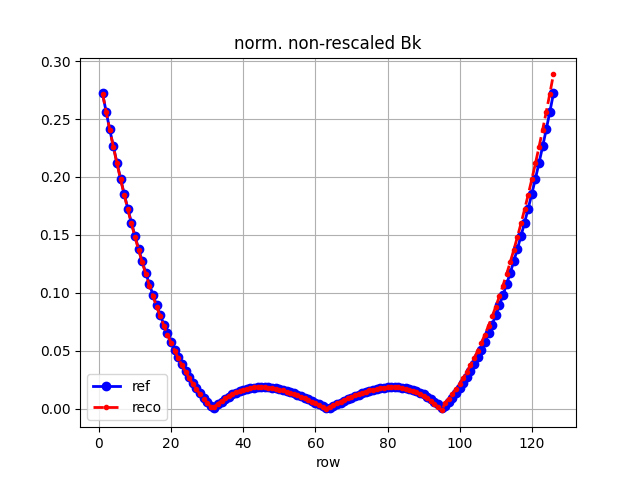

In [69]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# ---------------------------------------------------------------------------------------
# --- Compare with the QuCF computations ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def compare_to_qucf(sel_matrix, flag_save):
    name_qucf_hdf5 = "be_OUTPUT.hdf5"

    # --- Get reference diagonals (w.r.t x, not asin(x)) ---
    if sel_matrix == "Bk":
        factor_global = factor_global_Bk_
        D_ref, _ = mix.get_diag(Bk_.real, i_shift = 0)
        R_ref, _ = mix.get_diag(Bk_.real, i_shift = 1)
        L_ref, _ = mix.get_diag(Bk_.real, i_shift = -1)
    if sel_matrix == "Ba":
        R_ref, _ = mix.get_diag(Ba_.imag, i_shift = 1)
        L_ref, _ = mix.get_diag(Ba_.imag, i_shift = -1)

    # --- Read data from QuCF simulations ---
    dd_loc    = qucf_r.read_matrix_sparse(path_qucf_, name_qucf_hdf5) 

    # The matrix computed by the BE oracle:
    B_rec = dd_loc["A"].form_dense_matrix() * factor_global
    if sel_matrix == "Bk":
        B_rec = B_rec.real
        D_reco, _ = mix.get_diag(B_rec, i_shift = 0)
        R_reco, _ = mix.get_diag(B_rec, i_shift = 1)
        L_reco, _ = mix.get_diag(B_rec, i_shift = -1)
    if sel_matrix == "Ba":
        B_rec = B_rec.imag
        R_reco, _ = mix.get_diag(B_rec, i_shift = 1)
        L_reco, _ = mix.get_diag(B_rec, i_shift = -1)

    # # --- Error ---
    # log_err = np.zeros(len(diag_rec))
    # for ii in range(len(diag_rec)):
    #     temp = np.abs(diag_rec[ii] - diag_ref[ii])
    #     if temp <= 1e-16:
    #         temp = 0
    #     log_err[ii] = np.log10(temp)

    # --- PLOTTING main diagonal ---
    wr = 1
    if sel_matrix == "Bk":
        row_work = range(len(D_ref))

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(row_work[wr:-1],  D_ref[wr:-1],  '-b', marker='o', linewidth = 2, label = "ref")
        ax.plot(row_work[wr:-1], D_reco[wr:-1], '--r', marker='.', linewidth = 2, label = "reco")
        plt.xlabel('row')
        plt.title("norm. non-rescaled " + sel_matrix)
        plt.legend()
        plt.grid(True)
        plt.show()

    def temp():
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, diag_ref, color="b", linewidth = 2, linestyle='-',  label = "ref")
        # ax.plot(range_x, diag_rec, color="r", linewidth = 2, linestyle='--', label = "rec")
        # plt.xlabel('i')
        # plt.ylabel(str_label + " diag.")
        # plt.legend()
        # plt.grid(True)
        # plt.show() 

        # # --- PLOTTING error ---
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, log_err, color="b", linewidth = 2, linestyle='-')
        # plt.xlabel('i')
        # plt.ylabel("log10(err)")
        # plt.grid(True)
        # plt.show() 

        # # --- PLOTTING alternative ---
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, diag_alt, color="b", linewidth = 2, linestyle='-')
        # plt.xlabel('i')
        # plt.ylabel(str_label_alt + " diag.")
        # plt.grid(True)
        # plt.show() 

        # # --- Compare BE oracle matrix with the encoded matrix ---
        # mix.compare_matrices_dense(B_ref_, B_rec, flag_return_err=True)

        # # --- Save data ---
        # if flag_save:

        #     # - original profile -
        #     fname = "{:s}_REF.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_ref)

        #     # - reconstructed profile -
        #     fname = "{:s}_REC.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_rec)

        #     # - errors -
        #     fname = "{:s}_LOG_ERROR.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, log_err)
        return
    return
# ----------------------------------------------------------------------
compare_to_qucf(
    sel_matrix = "Bk", # "Ba" or "Bk"
    flag_save = False
)



--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:59:32
matrix name:  U_BE_kmax
N = 16

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:14
matrix name:  U_BE_a
N = 16

--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:57:31
matrix name:  U_BE_kmax
N = 128

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:44
matrix name:  U_BE_a
N = 128


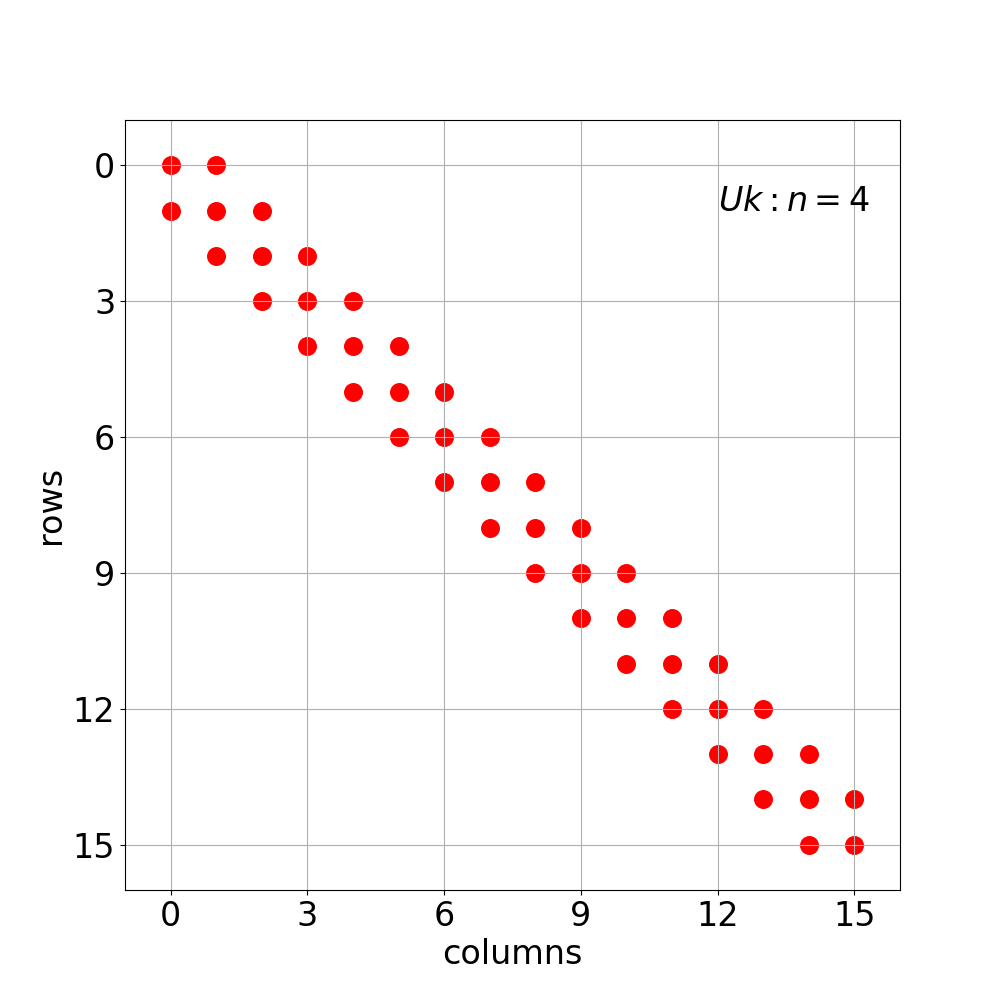

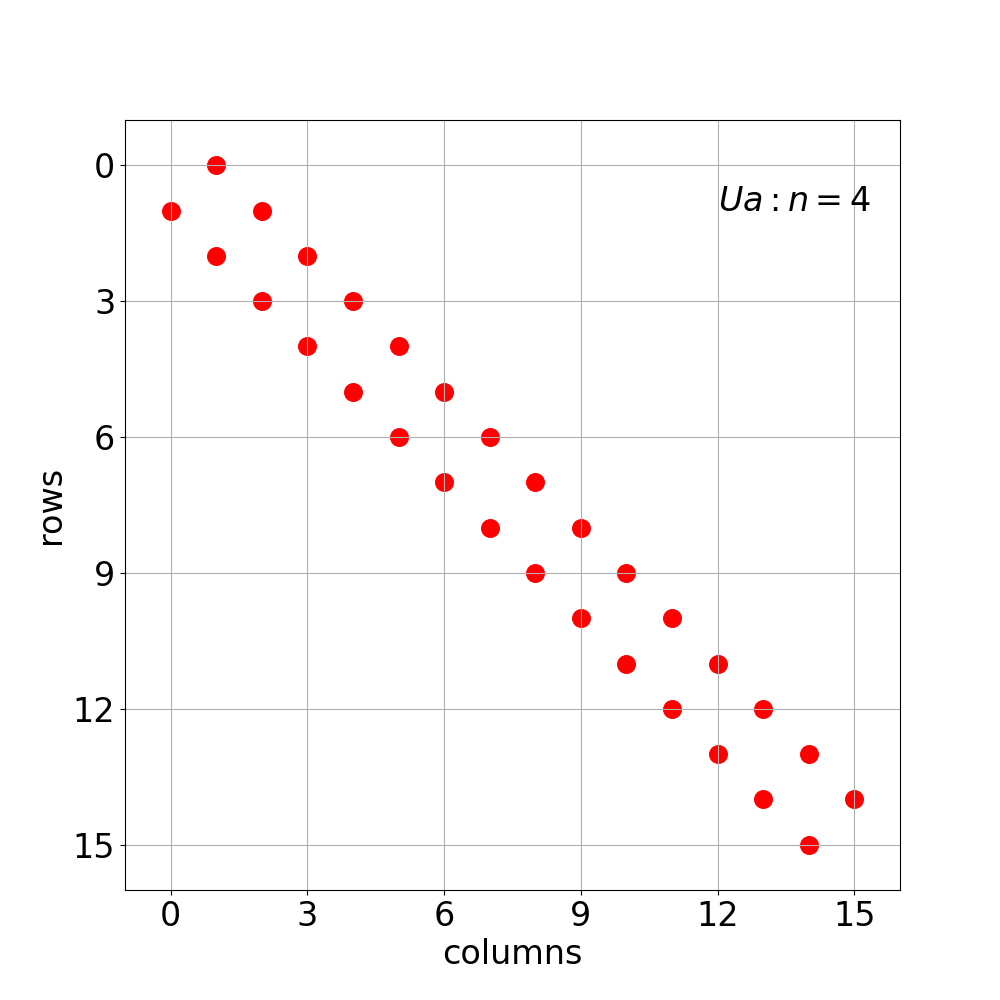

--- Elements in Dk in the diagonal 1 ---

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250 

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.

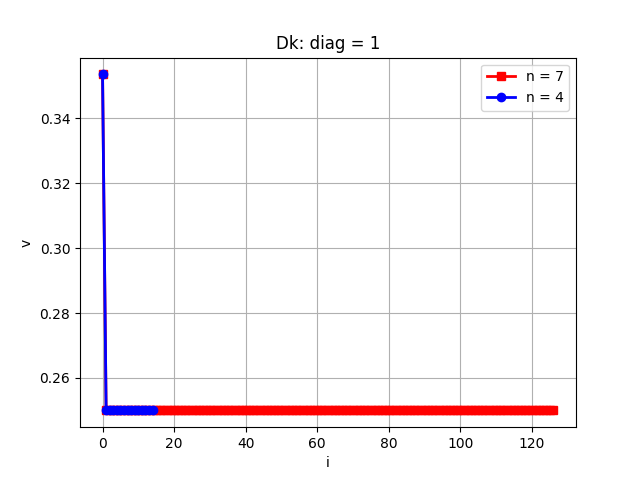

In [16]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# -------------------------------------------------------------------------
# --- Read D-matrices computed by the QuCF ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def reading_UD_matrices():
    path_D = path_qucf_ + "UD/"
    diff_n = [4, 7]
    dds_k = []
    dds_a = []
    for ii in range(len(diff_n)):
        print()
        print("--- Reading D-matrices for BE oracles of the matrix Ah for various nx.")
        fname_loc = "Dk-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_k.append(dd_loc)

        print()
        print("--- Reading D-matrices for BE oracles of the matrix Aa for various nx.")
        fname_loc = "Da-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_a.append(dd_loc)

    # --- Plot structures of D-matrices computed by the QuCF ---
    id_plot = 0
    dds_k[id_plot]["A"].plot_structure("Uk: n={:d}".format(diff_n[id_plot]))
    dds_a[id_plot]["A"].plot_structure("Ua: n={:d}".format(diff_n[id_plot]))
    return diff_n, dds_k, dds_a
# -----------------------------------------------------------------------------------
def print_plot_D_elements(id_shift, dds_print, str_matrix, flag_plot = True):
    colors = ["b", "r", "g"]
    markers = ["o", "s", "*"]

    # --- Printing ---
    print("--- Elements in {:s} in the diagonal {:d} ---".format(str_matrix, id_shift))
    print()
    for ii in range(len(diff_n)):
        mix.print_array(
            kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real,
            n_in_row = 8,
            ff=[6, 3, "f"]
        )
        print()

    # --- Plotting ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i1 in range(len(diff_n)):
            ii = len(diff_n) - i1 - 1
            n1 = diff_n[ii]
            ax.plot(
                np.array(range((1<<n1) - np.abs(id_shift))), 
                kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real, 
                color=colors[ii], linewidth = 2, linestyle='-', marker = markers[ii],
                label = "n = {:d}".format(n1)
            )
        plt.xlabel('i')
        plt.ylabel("v")
        plt.title(str_matrix + ": diag = {:d}".format(id_shift))
        plt.legend()
        plt.grid(True)
        plt.show() 
# -----------------------------------------------------------------------------------
# ---
diff_n, dds_k, dds_a = reading_UD_matrices()

# ---
id_diag = 1
print_plot_D_elements(id_diag, list(dds_k), "Dk")
# print_plot_D_elements(id_diag, list(dds_a), "Da")
del id_diag

In [ ]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_extr_odd_even_sum_PREV_RECENT(nx_fine):
    print("Taking {:s} sum".format(sel_sum_))

    # --- Compute the halfs ---
    if sel_half_ == 0: # left
        id_b = 0
        id_end = 2**(nx_-1)
    else: # right
        id_b = 2**(nx_-1)
        id_end = Nx_
    sum_R_k_half, _, sum_R_a_half, _, x_coarse \
        = kvn.get_HALF_sums_UW_KvN_LCHS_matrices_norm_rescaled(
            x_lin_, F_, norm_a_, norm_k_, dk_, id_b, id_end
        )
    
    # --- Fine grid ---
    x_fine = np.linspace(-1.0, 1.0, 2**nx_fine)
    
    # --- Choose the halfs ---
    if sel_sum_ == "D":
        diag_ref = np.array(dd_diags_ref_["diag_k_00"])
    if sel_sum_ == "Rk":
        sum_half = np.array(sum_R_k_half) 
        diag_ref_half = dd_diags_ref_["diag_k_p1"][id_b:id_end]
    if sel_sum_ == "Ra":
        sum_half = np.array(sum_R_a_half)
        diag_ref_half = dd_diags_ref_["diag_A_p1"][id_b:id_end]

    # --- Interpolate onto a finer grid ---
    if sel_sum_ == "D": 
        # --- Interpolating onto a fine grid ---
        x_coarse = np.linspace(-1.0, 1.0, len(sum_D_rs))
        f_interp = interpolate.CubicSpline(x_coarse, sum_D_rs)
        sum_work = f_interp(x_fine)
        
        f_interp = interpolate.CubicSpline(x_coarse, diag_ref)
        diag_ref = f_interp(x_fine)
    else:
        # --- Interpolating onto a fine grid ---
        x_coarse = np.linspace(-1.0, 1.0, len(sum_R_a_half))
        f_interp = interpolate.CubicSpline(x_coarse, sum_half)
        sum_work = f_interp(x_fine)
        
        x_coarse_diag = np.linspace(-1.0, 1.0, len(diag_ref_half))
        f_interp = interpolate.CubicSpline(x_coarse_diag, diag_ref_half)
        diag_ref_half = f_interp(x_fine)
        
        # --- Find the even and odd parts ---
        sum_work_even = 0.5 * (sum_work + sum_work[::-1])
        sum_work_odd  = 0.5 * (sum_work - sum_work[::-1])
        sum_work_ch = sum_work_even + sum_work_odd

        print("ref - check: {:0.3e}".format(
            np.max(np.abs(sum_work - sum_work_ch))
        ))

        # --- Plot the extrapolated sum ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            x_coarse, sum_half, 
            color='black', marker="o", linewidth = 2, linestyle=':',  
            label = "sum-half-original"
        )
        ax.plot(
            x_fine, sum_work, 
            color='red', linewidth = 2, linestyle='-',  
            label = "sum-work"
        )
        ax.plot(
            x_fine, sum_work_ch,  
            color='blue', linewidth = 2, linestyle='--',  
            label = "sum-work-ch"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Plot the even and odd parts ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            range(len(sum_work_even)), sum_work_even, 
            color='b', linewidth = 2, linestyle='--',  
            label = "sum-even"
        )
        ax.plot(
            range(len(sum_work_odd)), sum_work_odd, 
            color='r', linewidth = 2, linestyle='--',  
            label = "sum-odd"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # --- Return ---
    if sel_sum_ == "D": 
        return sum_work,         None,          None, x_fine, diag_ref,          None # no LCU
    else:
        return sum_work, sum_work_odd, sum_work_even, x_fine,     None, diag_ref_half
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sel_half_ = 0   # 0 or 1
nx_fine_ = 11

f_goal_, f_goal_odd_, f_goal_even_, x_fine_, diag_ref_, diag_ref_half_ =\
    get_extr_odd_even_sum(nx_fine = nx_fine_)

In [ ]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_extr_odd_even_sum(nx_fine):
    # --- Choosing a sum ---
    sum_ref = None
    row_ref = None
    
    print("Taking {:s} sum".format(sel_sum_))
    
    if sel_sum_ == "D":
        row_ref = row_D
        sum_ref = np.array(sum_D_rs)
        diag_ref = np.array(dd_diags_ref_["diag_k_00"])
    if sel_sum_ == "Rk":
        row_ref = row_R
        sum_ref = np.array(sum_R_k_rs) 
        diag_ref = np.array(dd_diags_ref_["diag_k_p1"])
    if sel_sum_ == "Ra":
        row_ref = row_R
        sum_ref = np.array(sum_R_a_rs)
        diag_ref = np.array(dd_diags_ref_["diag_A_p1"])


    
    if sel_sum_ == "D": 
        # --- Interpolating onto a fine grid ---
        x_fine = np.linspace(-1.0, 1.0, 2**nx_fine)
        x_coarse = np.linspace(-1.0, 1.0, len(sum_ref))
        f_interp = interpolate.CubicSpline(x_coarse, sum_ref)
        sum_work = f_interp(x_fine)
        
        f_interp = interpolate.CubicSpline(x_coarse, diag_ref)
        diag_ref = f_interp(x_fine)
    else:
        
        # --- Extrapolate the sum ---
        f_interp = interpolate.CubicSpline(row_ref, sum_ref)
        sum_extr = f_interp(row_D)

        # --- Take the half ---
        if sel_half_ == 0: # left
            id_end = 2**(nx_-1)
            row_half      = row_D[:id_end]
            sum_half      = sum_extr[:id_end]
            diag_ref_half = diag_ref[:id_end]
        else: # right
            id_b = 2**(nx_-1)
            row_half      = row_D[id_b:-1]
            sum_half      = sum_extr[id_b:-1]
            diag_ref_half = diag_ref[id_b:-1]
        del sum_extr
        
        # --- Interpolating onto a fine grid ---
        x_coarse = np.linspace(-1.0, 1.0, 2**(nx_-1))
                               
#         x_coarse = np.linspace(-1.0, 1.0, 2**nx_)
#         x_coarse = x_coarse[0:2**(nx_-1)]
        
        x_fine = np.linspace(-1.0, 1.0, 2**nx_fine)
#         x_fine = x_fine[0:2**(nx_fine-1)]
        
        f_interp = interpolate.CubicSpline(x_coarse, sum_half)
        sum_work = f_interp(x_fine)
        
        f_interp = interpolate.CubicSpline(x_coarse, diag_ref_half)
        diag_ref_half = f_interp(x_fine)
        
        # --- Find the even and odd parts ---
        sum_work_even = 0.5 * (sum_work + sum_work[::-1])
        sum_work_odd  = 0.5 * (sum_work - sum_work[::-1])
        sum_work_ch = sum_work_even + sum_work_odd

        print("ref - check: {:0.3e}".format(
            np.max(np.abs(sum_work - sum_work_ch))
        ))

        # --- Plot the extrapolated sum ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            x_coarse, sum_half, 
            color='black', marker="o", linewidth = 2, linestyle=':',  
            label = "sum-half-original"
        )
        ax.plot(
            x_fine, sum_work, 
            color='red', linewidth = 2, linestyle='-',  
            label = "sum-work"
        )
        ax.plot(
            x_fine, sum_work_ch,  
            color='blue', linewidth = 2, linestyle='--',  
            label = "sum-work-ch"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Plot the even and odd parts ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            range(len(sum_work_even)), sum_work_even, 
            color='b', linewidth = 2, linestyle='--',  
            label = "sum-even"
        )
        ax.plot(
            range(len(sum_work_odd)), sum_work_odd, 
            color='r', linewidth = 2, linestyle='--',  
            label = "sum-odd"
        )
        plt.xlabel('i')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # --- Return ---
    if sel_sum_ == "D": 
        return sum_work,         None,          None, x_coarse, x_fine, diag_ref,          None # no LCU
    else:
        return sum_work, sum_work_odd, sum_work_even, x_coarse, x_fine,     None, diag_ref_half
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sel_half_ = 0   # 0 or 1
nx_fine_ = 11

f_goal_, f_goal_odd_, f_goal_even_, x_coarse_, x_fine_, diag_ref_, diag_ref_half_ =\
    get_extr_odd_even_sum(nx_fine = nx_fine_)

In [ ]:
# ---------------------------------------------------------------
# --- Compute QSVT angles for the chosen sum ---
# ---------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(ch)
mix.reload_module(kvn)
def get_Cheb():
    # -----------------------------------------------------------------------------------
    def compute_Cheb_coefs(diag_ch, parity_1, Nd, flag_save_hdf5, flag_save_dat):
        sel_method = 0

        oo_ch_ = ch.Ch_()
        oo_ch_.choose_method(sel_method)
        oo_ch_.choose_func(
            -1, 0.0, 
            profile_in = diag_ch,
            name_prof  = sel_sum_,
            parity_in  = parity_1,
            path_root_in = "./jupyter-notebooks/NL/BE/coefs/",
            x_grid = x_fine_ # !!!
        )
        oo_ch_.compute_Ch(Nd)
#         oo_ch_.plot_reconstructed_function()
#         oo_ch_.plot_errors()
#         oo_ch_.plot_coefficients()

        if flag_save_hdf5:
            fname_ch = sel_sum_
            if parity_1 == 0:
                fname_ch += "_even"
            else:
                fname_ch += "_odd"
            oo_ch_.save_coefficients(fname_ch)
        return oo_ch_

    # -----------------------------------------------------------------------------------
    def test_recon_sin(oo_temp_ch_1, oo_temp_ch_2, flag_save_err):
        # sel_test = "goal_x"
        sel_test = "goal_asin"
        # sel_test = "diag"
        
        if sel_sum_ == "D":
            # --- Ref ---
            y_ref = -np.array(diag_ref_)
            
        else:
            # --- Ref ---
            if sel_test == 'goal_x':
                y_ref = np.array(f_goal_)
            elif sel_test == "goal_asin":
                temp = sum_R_a_x_rs[0:2**(nx_-1)]
                x_coarse = np.linspace(-1.0, 1.0, len(temp))
                f_interp = interpolate.CubicSpline(x_coarse, temp)
                y_ref = f_interp(x_fine_)
            elif sel_test == "diag":
                y_ref = -np.array(diag_ref_half_)
                # ref_even = 0.5 * (y_ref + y_ref[::-1])
                # ref_odd  = 0.5 * (y_ref - y_ref[::-1])
                # y_ref = ref_even

        # --- Reco ---
        if sel_test == 'goal_x':
            y_even = oo_temp_ch_1.get_rec_y_x()
            y_odd  = oo_temp_ch_2.get_rec_y_x()
            y_rec = y_even + y_odd
        elif sel_test == "goal_asin":
            y_even = oo_temp_ch_1.get_rec_y_sin_x()
            y_odd  = oo_temp_ch_2.get_rec_y_sin_x()
            y_rec = y_even + y_odd
        elif sel_test == "diag":
            y_even = oo_temp_ch_1.get_rec_y_x()
            y_odd  = oo_temp_ch_2.get_rec_y_x()
            y_rec = y_even + y_odd
    
        # --- PLOTTING ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(y_ref)),   y_ref,  "-",  color="b", linewidth = 2, label = "ref")
        ax.plot(range(len(x_fine_)), y_rec, "--",  color="r", linewidth = 2, label = "reco")
        plt.xlabel('i')
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show() 

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(x_fine_)),   y_ref - y_rec, "-",  color="b", linewidth = 2)
        plt.xlabel('i')
        plt.ylabel("y_ref - y_reco")
        plt.grid(True)
        plt.show() 
        return
    # -----------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------
    # --- Find the Chebyschev coefficients of the series ---
    # -----------------------------------------------------------------------------------
    flag_save_hdf5      = False
    flag_save_dat_coefs = False
    flag_save_dat_err   = False
    
    # REMARK: if Cheb = True, asin = False, then just a few Nd (e.g. Nd = 4) is necessary
    Nd = 200

    print()
    print("--------------------------------------------------------------------")
    print("--- Computing Chebyschev coefficients ---")
    print("--------------------------------------------------------------------")
    oo_temp_D = None
    oo_temp_even = None
    oo_temp_odd = None
    if sel_sum_ == "D":
        print("\n--- Main diagonal -----------------------------")
        oo_temp_D = compute_Cheb_coefs(
            f_goal_, 1, Nd, 
            flag_save_hdf5, 
            flag_save_dat_coefs
        )
        
        print()
        print("--------------------------------------------------------------------")
        print("--- Reconstructed profile ---")
        print("--------------------------------------------------------------------")
        test_recon_sin(oo_temp_D, None, flag_save_dat_err)
    else:
        print("\n--- EVEN part -----------------------------")
        oo_temp_even = compute_Cheb_coefs(
            f_goal_even_, 0, Nd, 
            flag_save_hdf5, 
            flag_save_dat_coefs
        )
        
        print("\n--- ODD part -----------------------------")
        oo_temp_odd = compute_Cheb_coefs(
            f_goal_odd_, 1, Nd, 
            flag_save_hdf5, 
            flag_save_dat_coefs
        )

        print()
        print("--------------------------------------------------------------------")
        print("--- Reconstructed profile ---")
        print("--------------------------------------------------------------------")
        test_recon_sin(oo_temp_even, oo_temp_odd, flag_save_dat_err)
    return
# ----------------------------------------------------------------------------------
get_Cheb()

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# ---------------------------------------------------------------------------------------
# --- Compare with the QuCF computations ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)

def compare_to_qucf(flag_save):
    # print()
    # print("key_diag_: ", key_diag_)
    # print("id_shift_: ", id_shift_)
    # print("flag_real_: ", flag_real_)
    # print()

    # --- Get reference diagonals (w.r.t x, not asin(x)) ---
    # diag_ref = np.array(dd_diags_ref_[key_diag_]) * coef_resc_

    diag_L_ref = dd_diags_ref_["diag_A_m1"]
    diag_D_ref = None
    diag_R_ref = dd_diags_ref_["diag_A_p1"]

    diag_R_ref_half = sum_R_a_x[:(Nx_//2)]
    ref_even = 0.5 * (diag_R_ref_half + diag_R_ref_half[::-1])


    # --- Read data from QuCF simulations ---
    dd_loc    = qucf_r.read_matrix_sparse(
        path_qucf_, 
        name_qucf_hdf5_
    ) 

    # The matrix computed by the BE oracle:
    # B_rec = dd_loc["A"].form_dense_matrix() * factor_global_
    B_rec = dd_loc["A"].form_dense_matrix()

    # take real or imaginary part
    flag_real_ = False
    if flag_real_:
        B_rec = B_rec.real
    else:
        B_rec = 2*B_rec.imag

    # The chosen diagonal:
    diag_rec_L, _ = np.array(mix.get_diag(B_rec, -1))
    diag_rec_D, _ = np.array(mix.get_diag(B_rec,  0))
    diag_rec_R, _ = np.array(mix.get_diag(B_rec,  1))

    # --- Normalization ---
    # diag_rec *= factor_global_
    # diag_rec /= coef_resc_ # because, the BE returns non-rescaled values !!!

    # # --- Error ---
    # log_err = np.zeros(len(diag_rec))
    # for ii in range(len(diag_rec)):
    #     temp = np.abs(diag_rec[ii] - diag_ref[ii])
    #     if temp <= 1e-16:
    #         temp = 0
    #     log_err[ii] = np.log10(temp)

    # --- PLOTTING profiles ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if diag_D_ref is not None:
        ax.plot(row_D, diag_D_ref, '-b', linewidth = 2, label = "ref-D")
        ax.plot(row_D, diag_rec_D, '--r', linewidth = 2, label = "reco-D")
        

    # ax.plot(row_R, diag_R_ref, color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_goal_[1:],    ref_even[1:], color='gray',   marker = "o", linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R[1:],      diag_rec_R[1:], color='orange', marker = "o", linewidth = 2, linestyle='--', label = "reco-R")

    # ax.plot(row_L, diag_L_ref,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    # ax.plot(row_L, diag_rec_L, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. non-rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    def temp():
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, diag_ref, color="b", linewidth = 2, linestyle='-',  label = "ref")
        # ax.plot(range_x, diag_rec, color="r", linewidth = 2, linestyle='--', label = "rec")
        # plt.xlabel('i')
        # plt.ylabel(str_label + " diag.")
        # plt.legend()
        # plt.grid(True)
        # plt.show() 

        # # --- PLOTTING error ---
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, log_err, color="b", linewidth = 2, linestyle='-')
        # plt.xlabel('i')
        # plt.ylabel("log10(err)")
        # plt.grid(True)
        # plt.show() 

        # # --- PLOTTING alternative ---
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(range_x, diag_alt, color="b", linewidth = 2, linestyle='-')
        # plt.xlabel('i')
        # plt.ylabel(str_label_alt + " diag.")
        # plt.grid(True)
        # plt.show() 

        # # --- Compare BE oracle matrix with the encoded matrix ---
        # mix.compare_matrices_dense(B_ref_, B_rec, flag_return_err=True)

        # # --- Save data ---
        # if flag_save:

        #     # - original profile -
        #     fname = "{:s}_REF.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_ref)

        #     # - reconstructed profile -
        #     fname = "{:s}_REC.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_rec)

        #     # - errors -
        #     fname = "{:s}_LOG_ERROR.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, log_err)
        return
    return
# ----------------------------------------------------------------------
compare_to_qucf(flag_save = False)